## Predicting skipped element of DNA sequence with Transformer

In [1]:
!pip install biopython

In [2]:
import numpy as np
import pandas as pd
import math
from Bio import SeqIO
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold
import os
import matplotlib.pyplot as plt
from tqdm import tqdm

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.callbacks import LearningRateScheduler, ReduceLROnPlateau
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [21]:
PATH_INPUT = '../input/dna-sequences/'
PATH_OUTPUT = './'
BATCH_SIZE = 1024
TRAIN_ONE_FOLD = True
RANDOM_SEED = 42
NUM_FOLDS = 8
NUM_EPOCHS = 1000

In [4]:
# Parsing initial sequences and creating Series with initial sequences
fasta_iterator = SeqIO.parse(open(PATH_INPUT+'mart_export.txt'),'fasta')

init_sequences = []
for fasta in fasta_iterator:
    sequence = str(fasta.seq)
    init_sequences.append(sequence)
    
init_seqs = pd.Series(init_sequences)

In [5]:
# Filtering initial sequences
init_seqs = init_seqs[init_seqs.transform(lambda x: ('A' in x)&('T' in x)&('C' in x)&('G' in x))]

# Removing "N" at the start of sequence
def remove_N(seq):
    i = 0
    for x in seq:
        if x == 'N':
            i+=1
        else: 
            break
        
    return seq[i:]

init_seqs = init_seqs.transform(lambda x: remove_N(x))

# Dropping if there are more then 4 distinct symbols in initial sequence and length < 61
init_seqs.drop(init_seqs.index[init_seqs.transform(lambda x: len(set(x)) != 4)], inplace=True)
init_seqs.drop(init_seqs.index[init_seqs.transform(lambda x: len(x) < 61)], inplace=True)
init_seqs.reset_index(inplace=True, drop=True)

# Converting strings to id lists
mapping = {'A': 1, 'C': 2, 'G': 3, 'T': 4}  # -1 for predictions
init_seqs = init_seqs.transform(lambda x: [mapping[symbol] for symbol in x])

In [ ]:
init_seqs.transform(lambda x: len(x)).describe()

In [6]:
# Creating sequences with random lengths beetween 11 and 61 out of parsed long sequences
# Then adding padding to bring sequences to equal lenghts and hide target element
seqs = []
targets = []
for elem in tqdm(init_seqs):
    i = 0
    while i < len(elem)-61:
        seq_with_pad = [0]*61  # 0 is an id of '<pad>'
        seq_length = np.random.randint(11,61)
        seq = elem[i:i+seq_length]
        j = np.random.randint(np.max([seq_length-31, 5]), np.min([31, seq_length-5]))
        target = seq[j]  # Creating target
        seq[j] = 0  # 
        seq_with_pad[30-j:30-j+seq_length] = seq
        seqs.append(seq_with_pad)
        targets.append(target)
        i+=seq_length
seqs = np.asarray(seqs).astype('float32').reshape(-1, 61, 1)
targets = np.asarray(targets).astype('float32').reshape(-1, 1) - 1
print(len(seqs), 'sequences obtained')

In [7]:
# Creating transformer block which will be used multiple times sequentially
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [8]:
# Creating embeddings which will be the input of transformer block
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, max_len, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim, mask_zero=True)
        self.pos_emb = layers.Embedding(input_dim=max_len, output_dim=embed_dim)

    def call(self, x):
        max_len = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=max_len, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [16]:
vocab_size = 5  # from 0 to 4
max_len = 61 
embed_dim = 64  # Embedding size for attention
num_heads = 12  # Number of attention heads
ff_dim = 128  # Hidden layer size in feed forward network inside transformer
dropout_rate = 0.05
num_blocks = 12

def build_model():
    inputs = layers.Input(shape=(max_len,))
    
    # POSITION EMBEDDING
    pos_embedding = TokenAndPositionEmbedding(max_len=max_len, vocab_size=vocab_size, embed_dim=embed_dim)
    x = pos_embedding(inputs)
    
    # TRANSFORMER BLOCKS
    for k in range(num_blocks):
        x_old = x
        transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim, dropout_rate)
        x = transformer_block(x)
        x = 0.7*x + 0.3*x_old  # SKIP CONNECTION
    
    # GLOBAL AVERAGE POOLING
    pooling = layers.GlobalAveragePooling1D()
    x = pooling(x)
    
    # PREDICTION LAYERS
    x = layers.Dense(128, activation="selu")(x)
    x = layers.Dropout(dropout_rate)(x)
    outputs = layers.Dense(vocab_size-1, activation="softmax")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
        
    return model

In [15]:
# Implementing TPU, defining strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
    BATCH_SIZE = strategy.num_replicas_in_sync * 64
    print("Running on TPU:", tpu.master())
    print(f"Batch Size: {BATCH_SIZE}")
    
except ValueError:
    strategy = tf.distribute.get_strategy()
    BATCH_SIZE = 512
    print(f"Running on {strategy.num_replicas_in_sync} replicas")
    print(f"Batch Size: {BATCH_SIZE}")

In [25]:
VERBOSE = 1
TRAIN_MODEL = True
VER = 2  # Version of model

with strategy.scope():
    accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
    kf = KFold(n_splits=NUM_FOLDS, shuffle=True, random_state=RANDOM_SEED)
    
    train_preds = []
    train_true = []
    test_preds = []
    test_true = []
    oof_preds = []
    oof_true = []
    test_folds = []
    
    # Train and validate on 80% of data, test on 20%
    for fold, (train_idx, val_idx) in enumerate(kf.split(seqs[:int(len(targets)*0.8)], targets[:int(len(targets)*0.8)])):
        print('-'*15, '>', f'Fold {fold}', '<', '-'*15)
        X_train, X_valid = seqs[train_idx], seqs[val_idx]
        y_train, y_valid = targets[train_idx], targets[val_idx]
        test_folds.append(val_idx)
        
        checkpoint_filepath = f"folds{fold}_{VER}.hdf5"

        model = build_model()
        opt = tf.keras.optimizers.Nadam(lr=0.0001)
        model.compile(optimizer=opt, loss="sparse_categorical_crossentropy", metrics=['sparse_categorical_accuracy'])
        
        # Initializing callbacks for training
        reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3,
                              patience=6, min_lr=0)
        
        early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=9)
        
        sv = keras.callbacks.ModelCheckpoint(
                checkpoint_filepath, monitor='val_loss', verbose=VERBOSE, save_best_only=True,
                save_weights_only=True, mode='auto', save_freq='epoch',
                options=None
                                            )
        
        if TRAIN_MODEL:
            history = model.fit(X_train, y_train, verbose=VERBOSE,
                                validation_data=(X_valid, y_valid), 
                                epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, callbacks=[reduce_lr, sv, early_stop]
                               )
            
            # Notification about the end of training proccess
            !wget "https://alarmerbot.ru/?key=10c705-98982c-21cbb1&message=Training%20in%20Kaggle%20is%20finished%21"
        else:
            model.load_weights(f'../input/tr-tf-tpu1/folds{fold}_{VER}.hdf5')
       
        
        # PREDICT TRAIN
        print('Predicting TRAIN...')
        train_preds.append( model.predict(X_train, batch_size=BATCH_SIZE, verbose=VERBOSE) )
        train_true.append( y_train )
        accuracy.update_state(train_true[-1], train_preds[-1])
        score = accuracy.result().numpy()
        print(f"Fold-{fold} | Train Score: {score}")
        
        # PREDICT OOF (VALIDATION)
        print('Predicting OOF...')
        oof_preds.append( model.predict(X_valid, batch_size=BATCH_SIZE, verbose=VERBOSE) )
        oof_true.append( y_valid )
        accuracy.update_state(oof_true[-1], oof_preds[-1])
        score = accuracy.result().numpy()
        print(f"Fold-{fold} | OOF Score: {score}")
        
        # PREDICT TEST
        print('Predicting TEST...')
        test_preds.append( model.predict(seqs[int(len(targets)*0.8):], batch_size=BATCH_SIZE, verbose=VERBOSE) )
        test_true.append( targets[int(len(targets)*0.8):] )
        accuracy.update_state(test_true[-1], test_preds[-1])
        score = accuracy.result().numpy()
        print(f"Fold-{fold} | Test Score: {score}")
        
        np.save(f'oof_v{VER}_trans', oof_preds)
        
        if TRAIN_ONE_FOLD: break

In [ ]:
losses, sc_accs, val_losses, vsc_accs = \
np.asarray(history.history['loss']).astype('float16'), \
np.asarray(history.history['sparse_categorical_accuracy']).astype('float16'), \
np.asarray(history.history['val_loss']).astype('float16'), \
np.asarray(history.history['val_sparse_categorical_accuracy']).astype('float16')

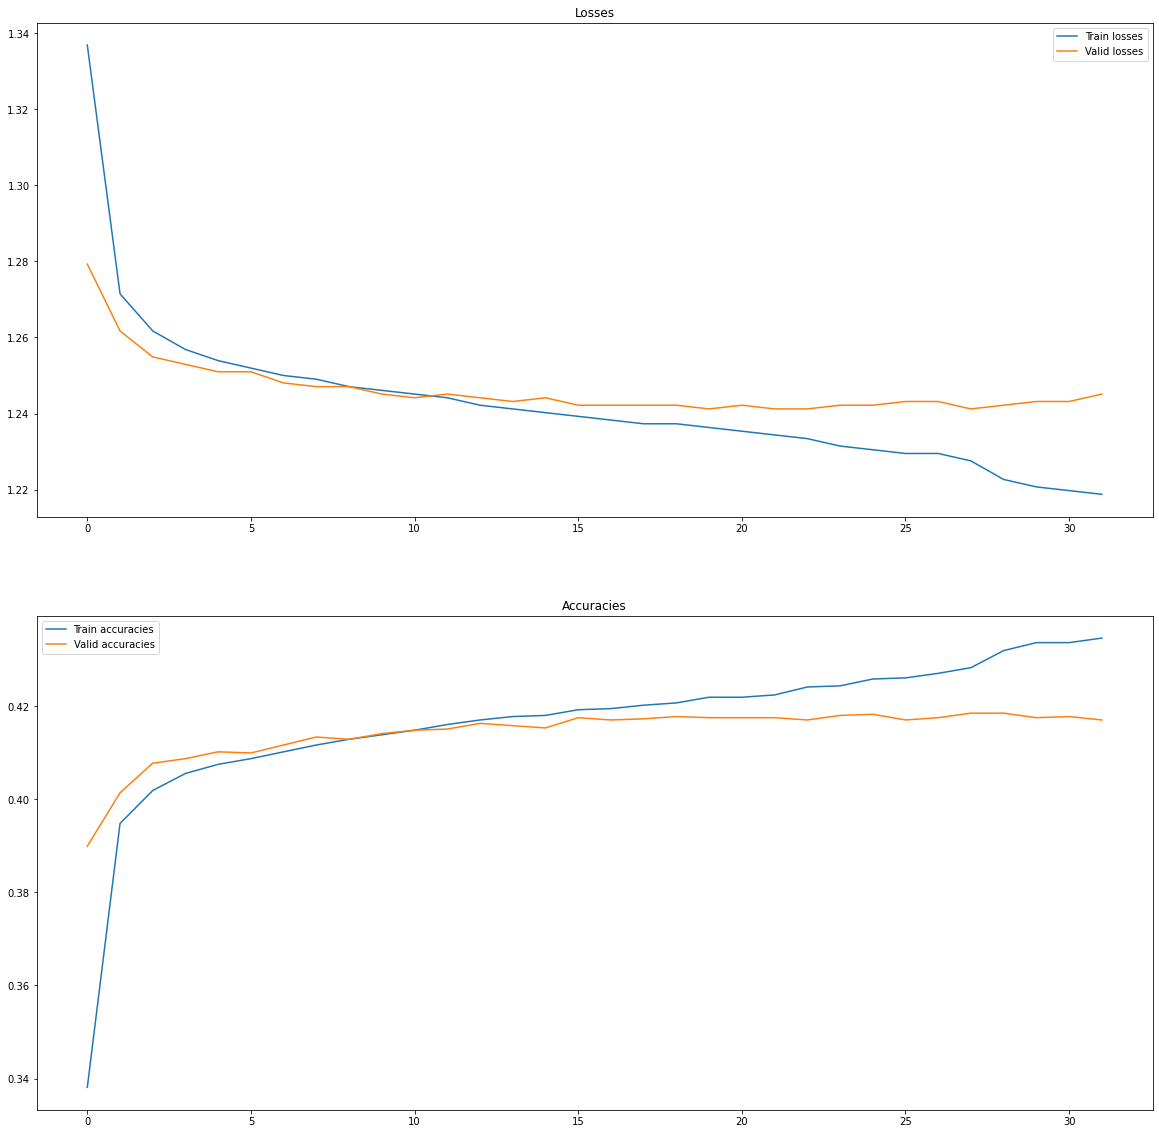

In [11]:
# Plotting training history
fig, (ax1, ax2) = plt.subplots(2, 1)
fig.set_size_inches(20, 20)
ax1.set_title('Losses')
ax1.plot(losses, label='Train losses')
ax1.plot(val_losses, label='Valid losses')
ax1.legend()
ax2.set_title('Accuracies')
ax2.plot(sc_accs, label = 'Train accuracies')
ax2.plot(vsc_accs, label = 'Valid accuracies')
ax2.legend()

TRAINING LOG

--------------- > Fold 0 < ---------------
Epoch 1/1000
2348/2348 [==============================] - 424s 150ms/step - loss: 1.3366 - sparse_categorical_accuracy: 0.3382 - val_loss: 1.2797 - val_sparse_categorical_accuracy: 0.3900

Epoch 00001: val_loss improved from inf to 1.27971, saving model to folds0_2.hdf5
Epoch 2/1000
2348/2348 [==============================] - 327s 139ms/step - loss: 1.2712 - sparse_categorical_accuracy: 0.3947 - val_loss: 1.2618 - val_sparse_categorical_accuracy: 0.4013

Epoch 00002: val_loss improved from 1.27971 to 1.26183, saving model to folds0_2.hdf5
Epoch 3/1000
2348/2348 [==============================] - 326s 139ms/step - loss: 1.2620 - sparse_categorical_accuracy: 0.4019 - val_loss: 1.2548 - val_sparse_categorical_accuracy: 0.4076

Epoch 00003: val_loss improved from 1.26183 to 1.25480, saving model to folds0_2.hdf5
Epoch 4/1000
2348/2348 [==============================] - 326s 139ms/step - loss: 1.2573 - sparse_categorical_accuracy: 0.4055 - val_loss: 1.2531 - val_sparse_categorical_accuracy: 0.4087

Epoch 00004: val_loss improved from 1.25480 to 1.25306, saving model to folds0_2.hdf5
Epoch 5/1000
2348/2348 [==============================] - 326s 139ms/step - loss: 1.2541 - sparse_categorical_accuracy: 0.4074 - val_loss: 1.2505 - val_sparse_categorical_accuracy: 0.4101

Epoch 00005: val_loss improved from 1.25306 to 1.25052, saving model to folds0_2.hdf5
Epoch 6/1000
2348/2348 [==============================] - 326s 139ms/step - loss: 1.2516 - sparse_categorical_accuracy: 0.4088 - val_loss: 1.2513 - val_sparse_categorical_accuracy: 0.4099

Epoch 00006: val_loss did not improve from 1.25052
Epoch 7/1000
2348/2348 [==============================] - 326s 139ms/step - loss: 1.2499 - sparse_categorical_accuracy: 0.4102 - val_loss: 1.2481 - val_sparse_categorical_accuracy: 0.4116

Epoch 00007: val_loss improved from 1.25052 to 1.24808, saving model to folds0_2.hdf5
Epoch 8/1000
2348/2348 [==============================] - 327s 139ms/step - loss: 1.2486 - sparse_categorical_accuracy: 0.4116 - val_loss: 1.2467 - val_sparse_categorical_accuracy: 0.4133

Epoch 00008: val_loss improved from 1.24808 to 1.24669, saving model to folds0_2.hdf5
Epoch 9/1000
2348/2348 [==============================] - 326s 139ms/step - loss: 1.2467 - sparse_categorical_accuracy: 0.4129 - val_loss: 1.2472 - val_sparse_categorical_accuracy: 0.4129

Epoch 00009: val_loss did not improve from 1.24669
Epoch 10/1000
2348/2348 [==============================] - 326s 139ms/step - loss: 1.2462 - sparse_categorical_accuracy: 0.4137 - val_loss: 1.2451 - val_sparse_categorical_accuracy: 0.4140

Epoch 00010: val_loss improved from 1.24669 to 1.24509, saving model to folds0_2.hdf5
Epoch 11/1000
2348/2348 [==============================] - 326s 139ms/step - loss: 1.2448 - sparse_categorical_accuracy: 0.4148 - val_loss: 1.2444 - val_sparse_categorical_accuracy: 0.4148

Epoch 00011: val_loss improved from 1.24509 to 1.24442, saving model to folds0_2.hdf5
Epoch 12/1000
2348/2348 [==============================] - 326s 139ms/step - loss: 1.2437 - sparse_categorical_accuracy: 0.4159 - val_loss: 1.2451 - val_sparse_categorical_accuracy: 0.4150

Epoch 00012: val_loss did not improve from 1.24442
Epoch 13/1000
2348/2348 [==============================] - 326s 139ms/step - loss: 1.2422 - sparse_categorical_accuracy: 0.4171 - val_loss: 1.2438 - val_sparse_categorical_accuracy: 0.4162

Epoch 00013: val_loss improved from 1.24442 to 1.24383, saving model to folds0_2.hdf5
Epoch 14/1000
2348/2348 [==============================] - 326s 139ms/step - loss: 1.2415 - sparse_categorical_accuracy: 0.4177 - val_loss: 1.2433 - val_sparse_categorical_accuracy: 0.4158

Epoch 00014: val_loss improved from 1.24383 to 1.24329, saving model to folds0_2.hdf5
Epoch 15/1000
2348/2348 [==============================] - 326s 139ms/step - loss: 1.2407 - sparse_categorical_accuracy: 0.4179 - val_loss: 1.2441 - val_sparse_categorical_accuracy: 0.4154

Epoch 00015: val_loss did not improve from 1.24329
Epoch 16/1000
2348/2348 [==============================] - 326s 139ms/step - loss: 1.2393 - sparse_categorical_accuracy: 0.4192 - val_loss: 1.2422 - val_sparse_categorical_accuracy: 0.4176

Epoch 00016: val_loss improved from 1.24329 to 1.24223, saving model to folds0_2.hdf5
Epoch 17/1000
2348/2348 [==============================] - 326s 139ms/step - loss: 1.2385 - sparse_categorical_accuracy: 0.4194 - val_loss: 1.2426 - val_sparse_categorical_accuracy: 0.4170

Epoch 00017: val_loss did not improve from 1.24223
Epoch 18/1000
2348/2348 [==============================] - 326s 139ms/step - loss: 1.2376 - sparse_categorical_accuracy: 0.4201 - val_loss: 1.2421 - val_sparse_categorical_accuracy: 0.4172

Epoch 00018: val_loss improved from 1.24223 to 1.24207, saving model to folds0_2.hdf5
Epoch 19/1000
2348/2348 [==============================] - 327s 139ms/step - loss: 1.2371 - sparse_categorical_accuracy: 0.4207 - val_loss: 1.2419 - val_sparse_categorical_accuracy: 0.4178

Epoch 00019: val_loss improved from 1.24207 to 1.24187, saving model to folds0_2.hdf5
Epoch 20/1000
2348/2348 [==============================] - 326s 139ms/step - loss: 1.2359 - sparse_categorical_accuracy: 0.4219 - val_loss: 1.2416 - val_sparse_categorical_accuracy: 0.4175

Epoch 00020: val_loss improved from 1.24187 to 1.24162, saving model to folds0_2.hdf5
Epoch 21/1000
2348/2348 [==============================] - 326s 139ms/step - loss: 1.2353 - sparse_categorical_accuracy: 0.4219 - val_loss: 1.2422 - val_sparse_categorical_accuracy: 0.4174

Epoch 00021: val_loss did not improve from 1.24162
Epoch 22/1000
2348/2348 [==============================] - 326s 139ms/step - loss: 1.2341 - sparse_categorical_accuracy: 0.4224 - val_loss: 1.2414 - val_sparse_categorical_accuracy: 0.4174

Epoch 00022: val_loss improved from 1.24162 to 1.24137, saving model to folds0_2.hdf5
Epoch 23/1000
2348/2348 [==============================] - 326s 139ms/step - loss: 1.2334 - sparse_categorical_accuracy: 0.4240 - val_loss: 1.2414 - val_sparse_categorical_accuracy: 0.4170

Epoch 00023: val_loss improved from 1.24137 to 1.24136, saving model to folds0_2.hdf5
Epoch 24/1000
2348/2348 [==============================] - 326s 139ms/step - loss: 1.2318 - sparse_categorical_accuracy: 0.4242 - val_loss: 1.2418 - val_sparse_categorical_accuracy: 0.4179

Epoch 00024: val_loss did not improve from 1.24136
Epoch 25/1000
2348/2348 [==============================] - 326s 139ms/step - loss: 1.2307 - sparse_categorical_accuracy: 0.4257 - val_loss: 1.2420 - val_sparse_categorical_accuracy: 0.4181

Epoch 00025: val_loss did not improve from 1.24136
Epoch 26/1000
2348/2348 [==============================] - 326s 139ms/step - loss: 1.2298 - sparse_categorical_accuracy: 0.4261 - val_loss: 1.2433 - val_sparse_categorical_accuracy: 0.4170

Epoch 00026: val_loss did not improve from 1.24136
Epoch 27/1000
2348/2348 [==============================] - 326s 139ms/step - loss: 1.2294 - sparse_categorical_accuracy: 0.4269 - val_loss: 1.2435 - val_sparse_categorical_accuracy: 0.4175

Epoch 00027: val_loss did not improve from 1.24136
Epoch 28/1000
2348/2348 [==============================] - 326s 139ms/step - loss: 1.2276 - sparse_categorical_accuracy: 0.4282 - val_loss: 1.2416 - val_sparse_categorical_accuracy: 0.4184

Epoch 00028: val_loss did not improve from 1.24136
Epoch 29/1000
2348/2348 [==============================] - 326s 139ms/step - loss: 1.2227 - sparse_categorical_accuracy: 0.4318 - val_loss: 1.2420 - val_sparse_categorical_accuracy: 0.4184

Epoch 00029: val_loss did not improve from 1.24136
Epoch 30/1000
2348/2348 [==============================] - 326s 139ms/step - loss: 1.2203 - sparse_categorical_accuracy: 0.4337 - val_loss: 1.2431 - val_sparse_categorical_accuracy: 0.4176

Epoch 00030: val_loss did not improve from 1.24136
Epoch 31/1000
2348/2348 [==============================] - 326s 139ms/step - loss: 1.2197 - sparse_categorical_accuracy: 0.4335 - val_loss: 1.2433 - val_sparse_categorical_accuracy: 0.4177

Epoch 00031: val_loss did not improve from 1.24136
Epoch 32/1000
2348/2348 [==============================] - 326s 139ms/step - loss: 1.2188 - sparse_categorical_accuracy: 0.4345 - val_loss: 1.2450 - val_sparse_categorical_accuracy: 0.4170

Epoch 00032: val_loss did not improve from 1.24136

Predicting TRAIN...
2348/2348 [==============================] - 112s 47ms/step
Fold-0 | Train Score: 0.43932464718818665
Predicting OOF...
336/336 [==============================] - 17s 51ms/step
Fold-0 | OOF Score: 0.436528742313385
Predicting TEST...
671/671 [==============================] - 33s 49ms/step
Fold-0 | Test Score: 0.43347784876823425